# Sleep Disorder Prediction Project

This project reads in sleep health data, preprocesses it, extracts and scales features, trains multiple machine learning models to predict sleep disorders, evaluates their performance, and saves the final SVM model for deployment.



## Import Libraries

This cell imports all necessary Python libraries for data manipulation, visualization, model training, evaluation, and persistence.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss
)
# from xgboost import XGBClassifier  # Uncomment if using XGBoost


## Data Loading and Initial Cleaning

Load the dataset, preview the first few rows, fill missing values in the 'Sleep Disorder' column with "None", and drop any remaining rows with missing data.


In [6]:
df = pd.read_csv("Updated_Sleep_Apnea_Sleep_health.csv")
print("Initial Data Preview:")
print(df.head())

df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')
df = df.dropna()
print("\nMissing Value Count After Dropping:")
print(df.isnull().sum())


Initial Data Preview:
   Age Alcohol/Smoking Addiction BMI Category Blood Pressure  Daily Steps  \
0   56                        No       Normal         143/84         4200   
1   46                        No       Normal         112/67        10000   
2   32                        No       Normal         110/71        10000   
3   60                        No        Obese         140/90         3000   
4   25                        No       Normal         148/80         3000   

  Gender  Heart Rate            Occupation  Person ID  \
0   Male          77     Software Engineer          1   
1   Male          75                Doctor          2   
2   Male          75                Doctor          3   
3   Male          85  Sales Representative          4   
4   Male          85  Sales Representative          5   

   Physical Activity Level  Quality of Sleep  Screen Time  \
0                       42                 6          3.0   
1                       60                 6      

## Feature Engineering

This cell performs feature engineering by:
- Splitting the 'Blood Pressure' column into 'Systolic' and 'Diastolic' features.
- Converting these features to integers.
- Dropping the original 'Blood Pressure' column.
- Creating new binary features for 'Sleep Walking' and 'Alcohol/Smoking Addiction'.
- Removing extra spaces from column names.
- Applying one-hot encoding on categorical columns.


In [7]:
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic'] = df['Systolic'].astype(int)
df['Diastolic'] = df['Diastolic'].astype(int)
df.drop('Blood Pressure', axis=1, inplace=True)

df['Sleep Walking'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Parasomnia' else 0)
df['Alcohol/Smoking Addiction'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Insomnia' else 0)

df.columns = df.columns.str.strip()

to_encode = ['BMI Category', 'Sleep Disorder']
available_to_encode = [col for col in to_encode if col in df.columns]
if available_to_encode:
    df = pd.get_dummies(df, columns=available_to_encode, drop_first=True)

bool_columns = df.select_dtypes(include='bool').columns.tolist()
df[bool_columns] = df[bool_columns].astype(int)


## Scaling Numeric Features

The numeric columns (`Screen Time`, `Sleep Duration`, `Stress Level`, `Systolic`, and `Diastolic`) are scaled using StandardScaler to standardize the data.


In [8]:
scale_cols = ['Screen Time', 'Sleep Duration', 'Stress Level', 'Systolic', 'Diastolic']
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])
print("\nScaled Feature Preview:")
print(df[scale_cols].head())



Scaled Feature Preview:
   Screen Time  Sleep Duration  Stress Level  Systolic  Diastolic
0     0.284094       -0.407601      0.283392  1.709030   0.543013
1     2.645232       -0.337319      1.251326 -0.979139  -1.410852
2    -0.896475       -0.337319     -0.684541 -1.152570  -0.951119
3     0.284094       -2.586362      0.767359  1.448885   1.232613
4     0.284094       -0.548167      1.251326  2.142606   0.083281


## Data Visualization

The scaled numeric features are visualized with histograms to check their distributions.


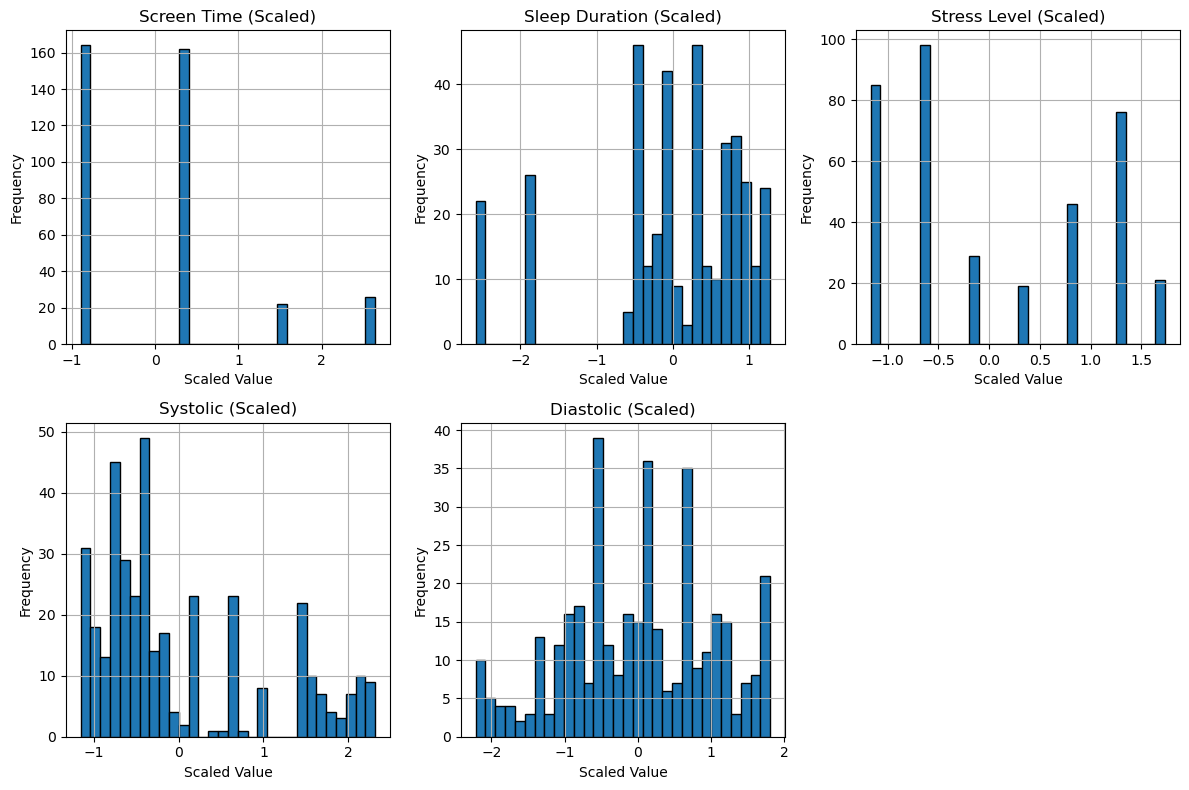

In [9]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(scale_cols):
    plt.subplot(2, 3, i + 1)
    df[col].hist(bins=30, edgecolor='black')
    plt.title(f'{col} (Scaled)')
    plt.xlabel('Scaled Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Preparing Data for Classification

The target variable is prepared by converting the one-hot encoded `Sleep Disorder` columns into a single label. The features are defined by dropping these target columns and further one-hot encoding any remaining categorical features. The data is then split into training and testing sets.


In [10]:
target_cols = [col for col in df.columns if col.startswith('Sleep Disorder_')]
y = df[target_cols].idxmax(axis=1)
X = df.drop(columns=target_cols)
X = pd.get_dummies(X, drop_first=True)
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("\nColumns used in modeling:")
print(df.columns.tolist())



Columns used in modeling:
['Age', 'Alcohol/Smoking Addiction', 'Daily Steps', 'Gender', 'Heart Rate', 'Occupation', 'Person ID', 'Physical Activity Level', 'Quality of Sleep', 'Screen Time', 'Screen Time (before Sleep)', 'Sleep Duration', 'Sleep Quality', 'Sleep Walking', 'Stress Level', 'Systolic', 'Diastolic', 'BMI Category_Normal Weight', 'BMI Category_Obese', 'BMI Category_Overweight', 'Sleep Disorder_Insomnia', 'Sleep Disorder_None', 'Sleep Disorder_Parasomnia', 'Sleep Disorder_Restless Leg Syndrome', 'Sleep Disorder_Sleep Apnea']


## Training Base Models: Logistic Regression & Random Forest

This cell initializes and trains both Logistic Regression and Random Forest models on the training data. It then makes predictions and prints the classification report along with the accuracy for both models.


In [11]:
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

logreg_preds = logreg.predict(X_test)
rf_preds = rf.predict(X_test)

print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, logreg_preds))
print("Accuracy:", accuracy_score(y_test, logreg_preds))

print("\n=== Random Forest Report ===")
print(classification_report(y_test, rf_preds))
print("Accuracy:", accuracy_score(y_test, rf_preds))



=== Logistic Regression Report ===
                                      precision    recall  f1-score   support

             Sleep Disorder_Insomnia       1.00      1.00      1.00        22
                 Sleep Disorder_None       1.00      1.00      1.00        19
           Sleep Disorder_Parasomnia       1.00      1.00      1.00        14
Sleep Disorder_Restless Leg Syndrome       1.00      1.00      1.00        10
          Sleep Disorder_Sleep Apnea       1.00      1.00      1.00        10

                            accuracy                           1.00        75
                           macro avg       1.00      1.00      1.00        75
                        weighted avg       1.00      1.00      1.00        75

Accuracy: 1.0

=== Random Forest Report ===
                                      precision    recall  f1-score   support

             Sleep Disorder_Insomnia       1.00      1.00      1.00        22
                 Sleep Disorder_None       1.00      1.00 

## Cross-Validation & Sanity Check

Perform 5-fold cross-validation on the Logistic Regression and Random Forest models. A sanity check with shuffled target labels is performed to ensure model validity.


In [12]:

logreg_scores = cross_val_score(logreg, X_scaled, y, cv=5)
rf_scores = cross_val_score(rf, X_scaled, y, cv=5)
print("\nLogReg Cross-Validated Accuracy:", logreg_scores.mean())
print("Random Forest Cross-Validated Accuracy:", rf_scores.mean())

y_shuffled = y.sample(frac=1.0, random_state=42)
logreg_shuffled_scores = cross_val_score(logreg, X_scaled, y_shuffled, cv=5)
print("LogReg Accuracy with Shuffled Labels:", logreg_shuffled_scores.mean())



LogReg Cross-Validated Accuracy: 1.0
Random Forest Cross-Validated Accuracy: 1.0
LogReg Accuracy with Shuffled Labels: 0.22738738738738737


## Training Additional Models: SVM, KNN, Gradient Boosting

This cell trains additional models (SVM, KNN, and Gradient Boosting) and prints their performance metrics.


In [13]:
models = {
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier()
    # "XGBoost": XGBClassifier()  # Uncomment if using XGBoost
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n=== {name} Report ===")
    print(classification_report(y_test, preds))



=== SVM Report ===
                                      precision    recall  f1-score   support

             Sleep Disorder_Insomnia       0.85      1.00      0.92        22
                 Sleep Disorder_None       1.00      0.95      0.97        19
           Sleep Disorder_Parasomnia       1.00      1.00      1.00        14
Sleep Disorder_Restless Leg Syndrome       1.00      0.90      0.95        10
          Sleep Disorder_Sleep Apnea       1.00      0.80      0.89        10

                            accuracy                           0.95        75
                           macro avg       0.97      0.93      0.95        75
                        weighted avg       0.95      0.95      0.95        75


=== KNN Report ===
                                      precision    recall  f1-score   support

             Sleep Disorder_Insomnia       0.84      0.95      0.89        22
                 Sleep Disorder_None       0.70      1.00      0.83        19
           Sleep Dis

## Saving the Final SVM Model

Retrain the SVM model on the entire dataset, then save the model, the scaler, and the feature column names using joblib.


In [14]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_scaled, y)

joblib.dump(svm_model, 'svm_sleep_disorder_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'model_columns.pkl')

print("\nSVM model, scaler, and feature columns have been saved!")



SVM model, scaler, and feature columns have been saved!


## Detailed SVM Model Evaluation

Evaluate the SVM model using the test set by computing the accuracy, confusion matrix, precision, recall, F1 score, ROC AUC, and log loss. The results are displayed graphically and numerically.



Accuracy of the SVM Model: 0.9466666666666667


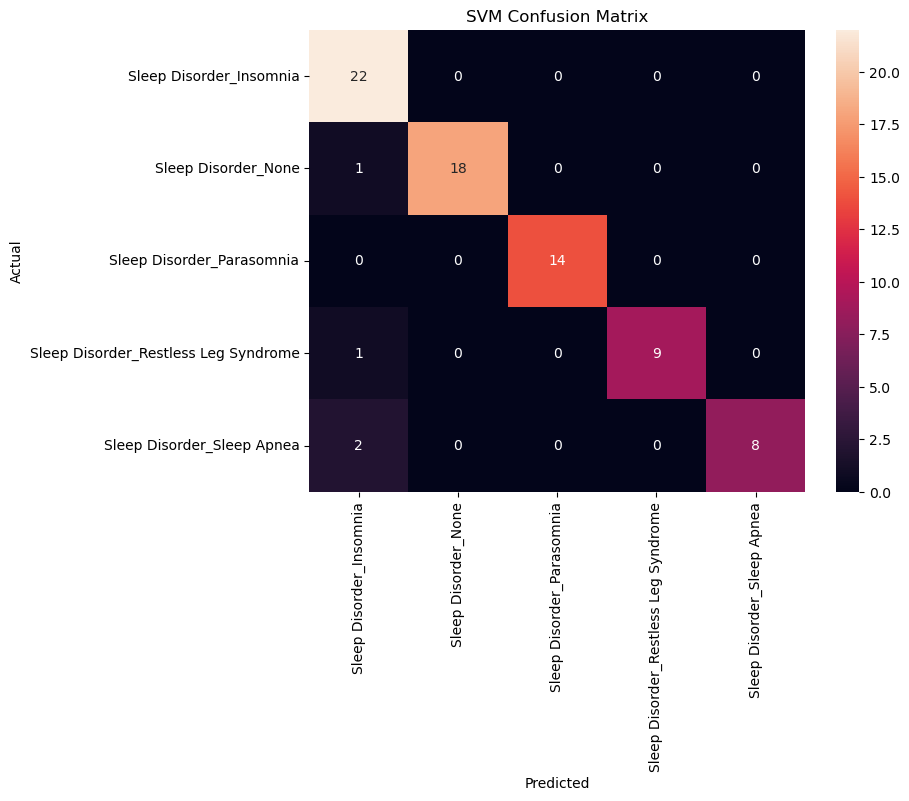

Precision (macro): 0.9692307692307693
Recall (macro): 0.9294736842105262
F1 Score (macro): 0.945179389916232
ROC AUC Score (macro, OVR): 0.9967351069982648
Log Loss: 0.20777559174004287


In [15]:
svm_model_eval = models["SVM"]
svm_preds = svm_model_eval.predict(X_test)
svm_probs = svm_model_eval.predict_proba(X_test)

acc = accuracy_score(y_test, svm_preds)
print("\nAccuracy of the SVM Model:", acc)

cm = confusion_matrix(y_test, svm_preds, labels=svm_model_eval.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=svm_model_eval.classes_, yticklabels=svm_model_eval.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision = precision_score(y_test, svm_preds, average='macro')
recall = recall_score(y_test, svm_preds, average='macro')
f1 = f1_score(y_test, svm_preds, average='macro')
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1 Score (macro):", f1)

y_test_bin = label_binarize(y_test, classes=svm_model_eval.classes_)
roc_auc = roc_auc_score(y_test_bin, svm_probs, average='macro', multi_class='ovr')
print("ROC AUC Score (macro, OVR):", roc_auc)

ll = log_loss(y_test, svm_probs)
print("Log Loss:", ll)
